# This jupyter notebook runs ARIMA and  SARIMAX (if needed) models to predict 12 months of forecasts for a set of retail products. 

# How to use: 

## 1. Choose product by its index
## 2. Run models for each product separately
## 3. Save the best forecast in y_test_T2

# Note: you need to run this jupyter separately for each product to get forecast for all of them


# Import data

In [1]:
import sys
import os
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from datetime import date


# Global Variables

In [2]:
sep = ';'
decimal = ','
X_train_T2_path ='C:/Users/Ania/Desktop/Nestle Case/X_train_T2.csv'
y_train_T2_path = 'C:/Users/Ania/Desktop/Nestle Case/y_train_T2.csv'
y_test_T2_path = 'C:/Users/Ania/Desktop/Nestle Case/y_test_T2.csv'




# Reading data with use of Data Cleaning

In [3]:
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"\\DataCleaningProgram")
    
from data_loader import DataLoader


dl = DataLoader(coefficient_nulls_removal=50,
                date_column_name=['date'],
                outliers_columns=['channel_2','channel_15','channel_17', 'channel_18',
                                   'channel_20','channel_29','channel_43','channel_45',
                                   'channel_52','channel_57','channel_75','channel_89',
                                   'channel_95','channel_101','channel_111'],
                datetime_duplicated_column_name = ['date_Duplicated'])


X_train_T2 = dl.get_initial_data(input_data_path=X_train_T2_path, sep= sep, decimal=decimal)
y_train_T2 = dl.get_initial_data(input_data_path=y_train_T2_path, sep= sep, decimal=decimal)
y_test_T2 = dl.get_initial_data(input_data_path=y_test_T2_path, sep= sep, decimal=decimal)
print(f"X_train_T2: {len(X_train_T2)}")
print(y_train_T2.head())

C:\Users\Ania\git\DataScienceProject
X_train_T2: 791
     key       date            y
0  10873  01Jan2012     0.000000
1  10873  01Feb2012   182.843665
2  10873  01Mar2012   618.877001
3  10873  01Apr2012  1201.535261
4  10873  01May2012   653.843499


# Taking a unique product to further analysis (input required)

In [4]:
#Create list of products
product_list = pd.unique(y_train_T2['key'])
print(product_list)

#First product
#YOUR INPUT IS NEEDED: select index of the product that will be analysed further. 
#The final forecast for this product will be saved in a file y_test_T2. 
single_product_number = product_list[4]
print(single_product_number)


#original set for first product
val_prod_1 = y_train_T2.loc[y_train_T2['key'] == single_product_number, 'y'].dropna()
print(val_prod_1)

#
val_prod_1 = val_prod_1.reset_index(drop = True)

[10873 37081 44612 57423 65101 65919 66606 72802 74523 75309 77390 93876]
65101
312    2515.545130
313    2815.215813
314    6981.378535
315    4648.579722
316    5672.052756
          ...     
385     515.055799
386    2569.534344
387    1600.425168
388    3637.202192
389    5021.884000
Name: y, Length: 78, dtype: float64


In [5]:
#Create train and test sets
x = int(0.8 * val_prod_1.shape[0])
val_prod_1_train = val_prod_1.iloc[:x]
val_prod_1_test = val_prod_1.iloc[x:]
val_prod_1.shape[0] == val_prod_1_train.shape[0] + val_prod_1_test.shape[0]

True

# This dataset is prepared for analysis and modeling

# ===================================

# Making ADF test  

In [6]:
import os
print(os.getcwd())

C:\Users\Ania\git\DataScienceProject\ArimaForecastingProgram


In [7]:
#ADF test for original data
val_prod_1_ADF_test = adfuller(val_prod_1_train)
print('ADF Statistic: %f' % val_prod_1_ADF_test[0])
print('p-value: %f' % val_prod_1_ADF_test[1])

#Hipoteza zerowa dla ADF mówi, że te dane są niestacjonarne, wartości powyżej 0.05 i bisko 1

ADF Statistic: -1.343681
p-value: 0.608959


1      299.670683
2     4166.162722
3    -2332.798813
4     1023.473034
5     3373.926431
         ...     
57   -1455.299680
58    -704.631589
59    2037.294314
60    -964.196690
61    -988.190928
Name: y, Length: 61, dtype: float64
ADF Statistic: -10.540237
p-value: 0.000000


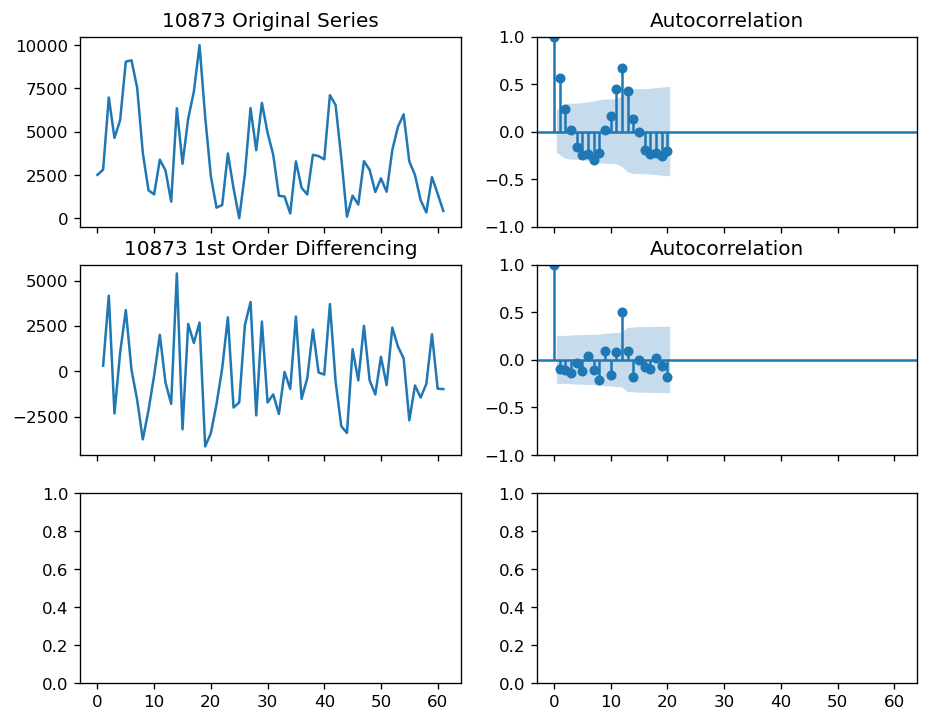

In [8]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(val_prod_1_train); axes[0, 0].set_title('10873 Original Series')
plot_acf(val_prod_1, ax=axes[0, 1], lags=20 )

#set of values for 1st Differencing
val_prod_1_diff_1 = val_prod_1_train.diff().iloc[1:]

# 1st Differencing
axes[1, 0].plot(val_prod_1_diff_1); axes[1, 0].set_title('10873 1st Order Differencing')
plot_acf(val_prod_1_diff_1, ax=axes[1, 1], lags=20)

#check if data is stationary for 1st Differencing
print(val_prod_1_diff_1)
val_prod_1_test_1 = adfuller(val_prod_1_diff_1)
print('ADF Statistic: %f' % val_prod_1_test_1[0])
print('p-value: %f' % val_prod_1_test_1[1])

plt.show()

# Second Differencing

ADF Statistic: -7.606145
p-value: 0.000000


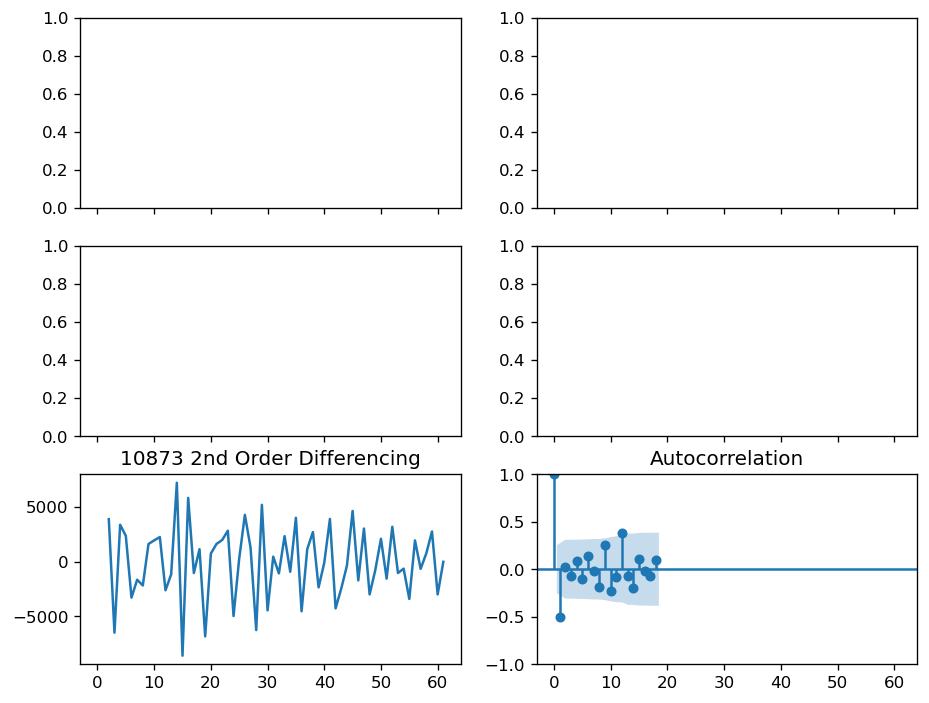

In [9]:
# set of values for 2nd Differencing
val_prod_1_diff_2 = val_prod_1_diff_1.diff().iloc[1:]

fig, axes = plt.subplots(3, 2, sharex=True)
axes[2, 0].plot(val_prod_1_diff_2); axes[2, 0].set_title('10873 2nd Order Differencing')
plot_acf(val_prod_1_diff_2, ax=axes[2, 1])

#check if data is stationary 2dn Differencing
val_prod_1_test_2 = adfuller(val_prod_1_diff_2)
print('ADF Statistic: %f' % val_prod_1_test_2[0])
print('p-value: %f' % val_prod_1_test_2[1])

plt.show()




# Finding paramethers of Arima

C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


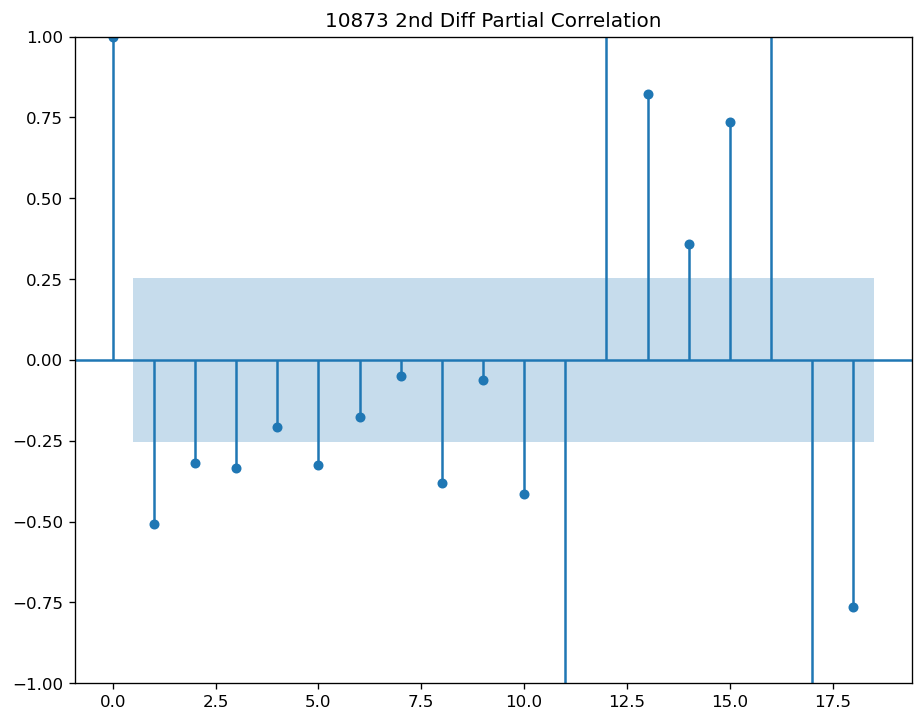

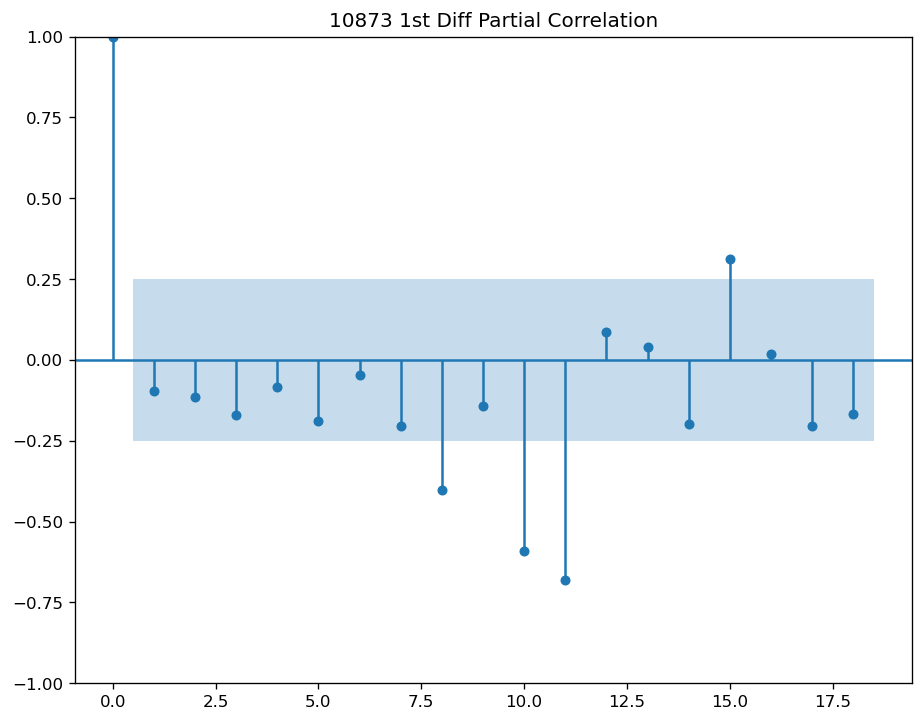

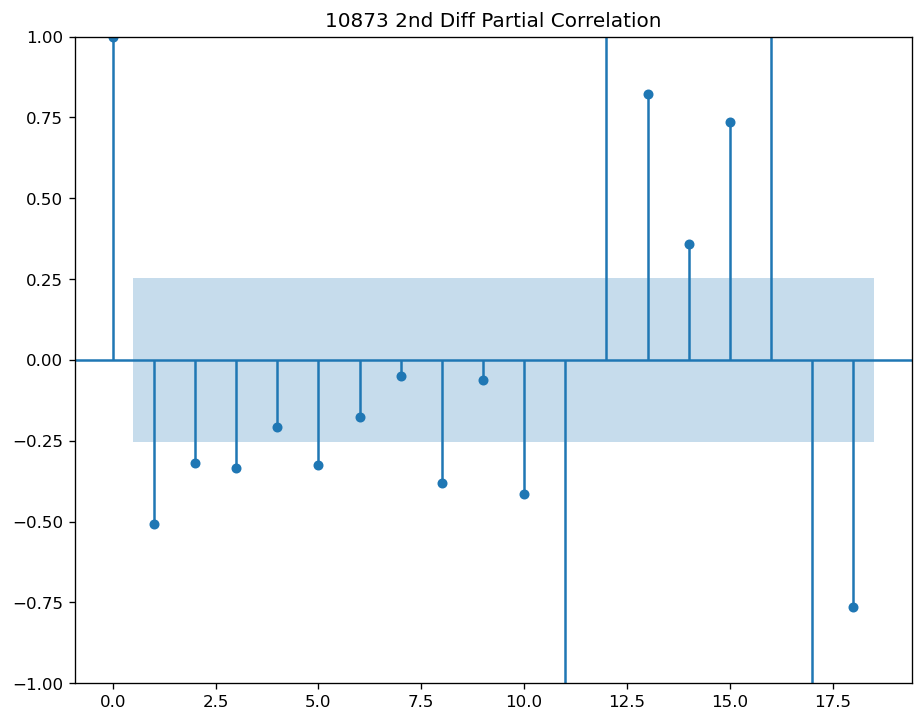

In [10]:
# p is numbers of lags; we take p from partial autocorrelation, we choose valyes which are outside of area of insignificance, 
# meaning the have the highest positive or negative correlation from all values 
#I have chosen 9 as it has the highest correlation of all values
p = 9

# d is a number of times we do differencing, 
#I have chosen 1 as after second differencing data seems over differenced in 2nd round
d = 1

# we take q form autocorrelation an it is a number of values which are outside area of insignificnce (the blue field)
#in autocorrelation for a first differencing we have 2 values totally outside of the blue field
q = 2

#10873 1st Diff Partial Correlation
plot_pacf(val_prod_1_diff_1, title='10873 1st Diff Partial Correlation')

#10873 1st Diff Partial Correlation
plot_pacf(val_prod_1_diff_2, title='10873 2nd Diff Partial Correlation')

# Fit Arima Model

In [11]:
#order tuple(p,d,q)
val_prod_1_ARIMA = ARIMA(val_prod_1_train, order=(8,1,2))
val_prod_1_model = val_prod_1_ARIMA.fit()
print(val_prod_1_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   62
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -537.592
Date:                Wed, 05 Apr 2023   AIC                           1097.184
Time:                        23:51:55   BIC                           1120.404
Sample:                             0   HQIC                          1106.284
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7962      0.317      2.512      0.012       0.175       1.417
ar.L2         -0.4219      0.274     -1.542      0.123      -0.958       0.114
ar.L3         -0.1958      0.271     -0.723      0.4

C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Forecast and Plot

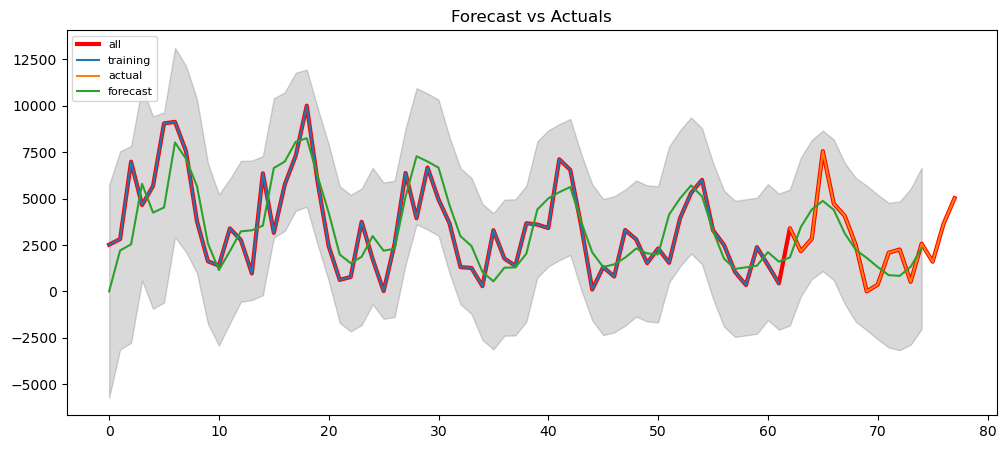

In [12]:
# Forecast
val_prod_1_forecast_conf = val_prod_1_model.get_prediction(start = 0, end = val_prod_1_train.shape[0] + 12)  # 95% conf

# Confidence intervals (all data within 95%)
lower_series = val_prod_1_forecast_conf.conf_int()['lower y']
upper_series = val_prod_1_forecast_conf.conf_int()['upper y']

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(val_prod_1.index, val_prod_1, label='all', lw=3, color='r')
plt.plot(val_prod_1_train.index, val_prod_1_train, label='training') 
plt.plot(val_prod_1_test.index, val_prod_1_test, label='actual')
plt.plot(val_prod_1_forecast_conf.predicted_mean, label='forecast')
plt.fill_between(lower_series.index, lower_series.values, upper_series.values, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

plt.savefig(f'ARIMA_{single_product_number}_{date.today()}.png', dpi=100)
plt.show()

# SARIMAX Grid Search Freamework

In [13]:
# Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
p=d=q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# Note: here we have 12 in the 's' position as we have monthly data

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

maxiter = 50

ans = []
for combination in pdq:
    for combinations in pdqs:
       
        model = sm.tsa.statespace.SARIMAX(val_prod_1_train,
                                        order=combination,
                                        seasonal_order=combinations,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = model.fit(maxiter=maxiter)
        
        #here we get a prediction of data that is a reflection of val_prod_1_test in terms of length and values
        prediction = output.predict(start=val_prod_1_test.index[0], end = val_prod_1_test.index[-1])
        
        #Now we compare compare prediction with val_prod_1_test data to see how good our prediction is
        #Mean squared error is:
        comparison = mean_squared_error(val_prod_1_test, prediction)
        ans.append([combination, combinations, comparison, output.bic])
        print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(combination, combinations, comparison, output.bic))

SARIMAX (0, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =11486387.947798673
SARIMAX (0, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =6727101.813953848
SARIMAX (0, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =6522376.6080521885
SARIMAX (0, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =764110.5173833403


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =944377.2020463952


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =940392.899531001
SARIMAX (0, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =5418932.517432281


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =5418932.517432277


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =1885846.0772109134
SARIMAX (0, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =1407363.2065962462
SARIMAX (0, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =893330.4923957186
SARIMAX (0, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =1104545.2698332942
SARIMAX (0, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =625736.581966831
SARIMAX (0, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =1003978.7246677581


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (1, 1, 2, 12)12 : BIC Calculated =960592.7525752094
SARIMAX (0, 0, 0) x (1, 2, 0, 12)12 : BIC Calculated =3225655.457871007
SARIMAX (0, 0, 0) x (1, 2, 1, 12)12 : BIC Calculated =1105821.8581036543


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (1, 2, 2, 12)12 : BIC Calculated =1112005.9081029003
SARIMAX (0, 0, 0) x (2, 0, 0, 12)12 : BIC Calculated =1253807.7854671348
SARIMAX (0, 0, 0) x (2, 0, 1, 12)12 : BIC Calculated =797835.1003206513


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 0) x (2, 0, 2, 12)12 : BIC Calculated =731106.9508612212
SARIMAX (0, 0, 0) x (2, 1, 0, 12)12 : BIC Calculated =638039.4288655581
SARIMAX (0, 0, 0) x (2, 1, 1, 12)12 : BIC Calculated =1241704.0347697407


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (2, 1, 2, 12)12 : BIC Calculated =1017444.1988692702
SARIMAX (0, 0, 0) x (2, 2, 0, 12)12 : BIC Calculated =2880637.2205717163


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 0) x (2, 2, 1, 12)12 : BIC Calculated =7894871.49347833


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 0) x (2, 2, 2, 12)12 : BIC Calculated =1091224.405143266
SARIMAX (0, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =11382116.054203562
SARIMAX (0, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =6694589.969631427


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 1) x (0, 0, 2, 12)12 : BIC Calculated =6223137.595606409
SARIMAX (0, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =775365.0778016803
SARIMAX (0, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =901640.4999133907


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 1) x (0, 1, 2, 12)12 : BIC Calculated =855667.9312184242
SARIMAX (0, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =5242155.333778268


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 1) x (0, 2, 1, 12)12 : BIC Calculated =5290539.521415692
SARIMAX (0, 0, 1) x (0, 2, 2, 12)12 : BIC Calculated =3326340.0583816785
SARIMAX (0, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =1363962.336850279
SARIMAX (0, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =876818.3365311241


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =1088149.5373528802
SARIMAX (0, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =626987.0200111151
SARIMAX (0, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =980989.9825514568


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =885371.7700190542
SARIMAX (0, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =3275222.676831674
SARIMAX (0, 0, 1) x (1, 2, 1, 12)12 : BIC Calculated =1147255.6605064312


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 1) x (1, 2, 2, 12)12 : BIC Calculated =2747765.2817164143
SARIMAX (0, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =1258909.4582146967


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =860412.7285929751


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 1) x (2, 0, 2, 12)12 : BIC Calculated =884744.7947158159
SARIMAX (0, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =865170.949444852
SARIMAX (0, 0, 1) x (2, 1, 1, 12)12 : BIC Calculated =1436744.170049695


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 1) x (2, 1, 2, 12)12 : BIC Calculated =1061687.5024290145
SARIMAX (0, 0, 1) x (2, 2, 0, 12)12 : BIC Calculated =3667689.148909897
SARIMAX (0, 0, 1) x (2, 2, 1, 12)12 : BIC Calculated =3618017.9815501757


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 1) x (2, 2, 2, 12)12 : BIC Calculated =8480127.211454134
SARIMAX (0, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =11637474.359141082
SARIMAX (0, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =7250084.413733772


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 2) x (0, 0, 2, 12)12 : BIC Calculated =6238954.006576784
SARIMAX (0, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =865288.9187228812
SARIMAX (0, 0, 2) x (0, 1, 1, 12)12 : BIC Calculated =914035.8949823747


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 2) x (0, 1, 2, 12)12 : BIC Calculated =811726.6793594251
SARIMAX (0, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =4962898.5557741
SARIMAX (0, 0, 2) x (0, 2, 1, 12)12 : BIC Calculated =5829545.25753437


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (0, 2, 2, 12)12 : BIC Calculated =2889895.99972294
SARIMAX (0, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =1356133.115705873
SARIMAX (0, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =841137.2883164674


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =1458702.6965911472
SARIMAX (0, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =651369.5447188381
SARIMAX (0, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =942279.2893918334


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 2) x (1, 1, 2, 12)12 : BIC Calculated =788280.709571392
SARIMAX (0, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =3481982.180140516
SARIMAX (0, 0, 2) x (1, 2, 1, 12)12 : BIC Calculated =873133.4020302447


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (1, 2, 2, 12)12 : BIC Calculated =1019588.5580956313
SARIMAX (0, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =1319379.0571463741


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =2433928.542554874


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =876000.6572974082
SARIMAX (0, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =915843.1513510051
SARIMAX (0, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =1316080.7922184533


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =976704.9589211922
SARIMAX (0, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =5273393.140742311


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 2) x (2, 2, 1, 12)12 : BIC Calculated =5234608.226427086


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 0, 2) x (2, 2, 2, 12)12 : BIC Calculated =11193548.513279844
SARIMAX (0, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =9240511.307206849
SARIMAX (0, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =7694750.974345095
SARIMAX (0, 1, 0) x (0, 0, 2, 12)12 : BIC Calculated =7589963.228288481
SARIMAX (0, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =3038601.859047916
SARIMAX (0, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =764520.2896162737


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 0) x (0, 1, 2, 12)12 : BIC Calculated =742716.5586862101
SARIMAX (0, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =15621019.036419412
SARIMAX (0, 1, 0) x (0, 2, 1, 12)12 : BIC Calculated =15621019.036419395


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 0) x (0, 2, 2, 12)12 : BIC Calculated =4763783.24236528
SARIMAX (0, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =5579949.788271949
SARIMAX (0, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =1422160.9073863532


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 0) x (1, 0, 2, 12)12 : BIC Calculated =1485229.3250173056
SARIMAX (0, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =1553278.6389122668
SARIMAX (0, 1, 0) x (1, 1, 1, 12)12 : BIC Calculated =748580.5458450849


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 0) x (1, 1, 2, 12)12 : BIC Calculated =702270.2516190776
SARIMAX (0, 1, 0) x (1, 2, 0, 12)12 : BIC Calculated =16655244.50702349
SARIMAX (0, 1, 0) x (1, 2, 1, 12)12 : BIC Calculated =2061373.396966792


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 0) x (1, 2, 2, 12)12 : BIC Calculated =2732376.6241150186
SARIMAX (0, 1, 0) x (2, 0, 0, 12)12 : BIC Calculated =4661325.726857157
SARIMAX (0, 1, 0) x (2, 0, 1, 12)12 : BIC Calculated =1276636.1707911864
SARIMAX (0, 1, 0) x (2, 0, 2, 12)12 : BIC Calculated =1239570.0487514068
SARIMAX (0, 1, 0) x (2, 1, 0, 12)12 : BIC Calculated =868867.2620944707
SARIMAX (0, 1, 0) x (2, 1, 1, 12)12 : BIC Calculated =1024508.3387264793


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 0) x (2, 1, 2, 12)12 : BIC Calculated =728741.2970545199
SARIMAX (0, 1, 0) x (2, 2, 0, 12)12 : BIC Calculated =5550987.866395751


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 0) x (2, 2, 1, 12)12 : BIC Calculated =3049043.183869969


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 0) x (2, 2, 2, 12)12 : BIC Calculated =6363188.8498565955
SARIMAX (0, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =8562254.423532061
SARIMAX (0, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =3253300.3980189865


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 1) x (0, 0, 2, 12)12 : BIC Calculated =1879654.7057325612
SARIMAX (0, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =1281883.1785396524
SARIMAX (0, 1, 1) x (0, 1, 1, 12)12 : BIC Calculated =816067.7482066094


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 1) x (0, 1, 2, 12)12 : BIC Calculated =837859.7618574258
SARIMAX (0, 1, 1) x (0, 2, 0, 12)12 : BIC Calculated =6298590.464364906


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 1) x (0, 2, 1, 12)12 : BIC Calculated =15415188.858955644
SARIMAX (0, 1, 1) x (0, 2, 2, 12)12 : BIC Calculated =1695739.0742892197
SARIMAX (0, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =1168120.9968021307
SARIMAX (0, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =1068060.5485432246


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 1) x (1, 0, 2, 12)12 : BIC Calculated =1249778.7285674894
SARIMAX (0, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =858693.5169219127
SARIMAX (0, 1, 1) x (1, 1, 1, 12)12 : BIC Calculated =820037.2266627545


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 1) x (1, 1, 2, 12)12 : BIC Calculated =727267.5245729683
SARIMAX (0, 1, 1) x (1, 2, 0, 12)12 : BIC Calculated =4185590.501427631


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 1) x (1, 2, 1, 12)12 : BIC Calculated =886471.1344211411
SARIMAX (0, 1, 1) x (1, 2, 2, 12)12 : BIC Calculated =988374.8629289507
SARIMAX (0, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =1151364.0420868963
SARIMAX (0, 1, 1) x (2, 0, 1, 12)12 : BIC Calculated =1127058.3765550053


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 1) x (2, 0, 2, 12)12 : BIC Calculated =1113526.2059693327
SARIMAX (0, 1, 1) x (2, 1, 0, 12)12 : BIC Calculated =899616.3637678383


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 1) x (2, 1, 1, 12)12 : BIC Calculated =955057.7281874127
SARIMAX (0, 1, 1) x (2, 1, 2, 12)12 : BIC Calculated =738068.4609519416
SARIMAX (0, 1, 1) x (2, 2, 0, 12)12 : BIC Calculated =2568439.8179841777
SARIMAX (0, 1, 1) x (2, 2, 1, 12)12 : BIC Calculated =1589213.0114047353


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 1) x (2, 2, 2, 12)12 : BIC Calculated =987926.7433149454
SARIMAX (0, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =3650765.7766278866
SARIMAX (0, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =2847879.7058722842


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 2) x (0, 0, 2, 12)12 : BIC Calculated =1835317.206374803
SARIMAX (0, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =1165852.064516109
SARIMAX (0, 1, 2) x (0, 1, 1, 12)12 : BIC Calculated =791770.3028317842


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 2) x (0, 1, 2, 12)12 : BIC Calculated =1035056.7366187026
SARIMAX (0, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =6310699.653804736


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 2) x (0, 2, 1, 12)12 : BIC Calculated =8205652.975359451


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 2) x (0, 2, 2, 12)12 : BIC Calculated =5915409.716275087
SARIMAX (0, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =1156053.7989078644
SARIMAX (0, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =1067739.0105984574


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 2) x (1, 0, 2, 12)12 : BIC Calculated =1190819.924134993
SARIMAX (0, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =932905.58050819
SARIMAX (0, 1, 2) x (1, 1, 1, 12)12 : BIC Calculated =802511.0948074174


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 2) x (1, 1, 2, 12)12 : BIC Calculated =892116.0536470206
SARIMAX (0, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =2953516.6268882975
SARIMAX (0, 1, 2) x (1, 2, 1, 12)12 : BIC Calculated =1427995.6005678559


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 2) x (1, 2, 2, 12)12 : BIC Calculated =4537132.397856568
SARIMAX (0, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =1166841.5772144948
SARIMAX (0, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =1125979.222636047


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 2) x (2, 0, 2, 12)12 : BIC Calculated =1144644.9583521795
SARIMAX (0, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =994177.3907917723
SARIMAX (0, 1, 2) x (2, 1, 1, 12)12 : BIC Calculated =832512.7242901125


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 1, 2) x (2, 1, 2, 12)12 : BIC Calculated =1025598.5934522786
SARIMAX (0, 1, 2) x (2, 2, 0, 12)12 : BIC Calculated =4272857.334513715


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 2) x (2, 2, 1, 12)12 : BIC Calculated =4148480.414283466


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 1, 2) x (2, 2, 2, 12)12 : BIC Calculated =1199735.1014781806
SARIMAX (0, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =137517015.26787072
SARIMAX (0, 2, 0) x (0, 0, 1, 12)12 : BIC Calculated =52409520.65897851
SARIMAX (0, 2, 0) x (0, 0, 2, 12)12 : BIC Calculated =96415137.7709483
SARIMAX (0, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =4412984.469917004


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (0, 1, 1, 12)12 : BIC Calculated =4412984.469915364
SARIMAX (0, 2, 0) x (0, 1, 2, 12)12 : BIC Calculated =810928.7545059585
SARIMAX (0, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =120884108.84162688
SARIMAX (0, 2, 0) x (0, 2, 1, 12)12 : BIC Calculated =16237931.65149865


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (0, 2, 2, 12)12 : BIC Calculated =61731258.77739143
SARIMAX (0, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =45278913.169745505
SARIMAX (0, 2, 0) x (1, 0, 1, 12)12 : BIC Calculated =14406590.851725934


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 0) x (1, 0, 2, 12)12 : BIC Calculated =17254468.52576568
SARIMAX (0, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =5602960.541909288


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (1, 1, 1, 12)12 : BIC Calculated =11277237.67827571
SARIMAX (0, 2, 0) x (1, 1, 2, 12)12 : BIC Calculated =5197113.638197616
SARIMAX (0, 2, 0) x (1, 2, 0, 12)12 : BIC Calculated =15494603.909275694


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (1, 2, 1, 12)12 : BIC Calculated =4624038.757171132


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (1, 2, 2, 12)12 : BIC Calculated =2764897.213887887
SARIMAX (0, 2, 0) x (2, 0, 0, 12)12 : BIC Calculated =78584575.67416301
SARIMAX (0, 2, 0) x (2, 0, 1, 12)12 : BIC Calculated =1547553.9055424836


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (2, 0, 2, 12)12 : BIC Calculated =16088926.321970284
SARIMAX (0, 2, 0) x (2, 1, 0, 12)12 : BIC Calculated =20021295.744873554
SARIMAX (0, 2, 0) x (2, 1, 1, 12)12 : BIC Calculated =12482356.766999047


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (2, 1, 2, 12)12 : BIC Calculated =3683852.0058076656
SARIMAX (0, 2, 0) x (2, 2, 0, 12)12 : BIC Calculated =5628358.42209232


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 0) x (2, 2, 1, 12)12 : BIC Calculated =30456342.39189751


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =7075406.109275252
SARIMAX (0, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =9109007.674297163
SARIMAX (0, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =9202165.287492715


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =9161863.94499973
SARIMAX (0, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =6143013.052334132


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =467078459.13005775
SARIMAX (0, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =1544981.4045522483
SARIMAX (0, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =10802935.22621695


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (0, 2, 1, 12)12 : BIC Calculated =1674580.3139487198


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (0, 2, 2, 12)12 : BIC Calculated =4249723.762257794
SARIMAX (0, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =8715918.46799381
SARIMAX (0, 2, 1) x (1, 0, 1, 12)12 : BIC Calculated =4898815.963273436


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 1) x (1, 0, 2, 12)12 : BIC Calculated =2240079.03485739
SARIMAX (0, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =3502573.083282098


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (1, 1, 1, 12)12 : BIC Calculated =763694116.9722688


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 1) x (1, 1, 2, 12)12 : BIC Calculated =1582601.0360815981
SARIMAX (0, 2, 1) x (1, 2, 0, 12)12 : BIC Calculated =11643903.597895999


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (1, 2, 1, 12)12 : BIC Calculated =1318783.343865275


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (1, 2, 2, 12)12 : BIC Calculated =1052748.2016024399
SARIMAX (0, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =6173307.237461795
SARIMAX (0, 2, 1) x (2, 0, 1, 12)12 : BIC Calculated =1121585.1816358913


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 1) x (2, 0, 2, 12)12 : BIC Calculated =3309851.018713934
SARIMAX (0, 2, 1) x (2, 1, 0, 12)12 : BIC Calculated =1013023.9039524627


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (2, 1, 1, 12)12 : BIC Calculated =474258162.56041396


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =1635997.7863236433
SARIMAX (0, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =3898324.915405809


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =10601231.01727599


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =1843533.1348672104
SARIMAX (0, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =8866991.466016073
SARIMAX (0, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =4368913.175056113


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =7536653.274160836
SARIMAX (0, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =894037.9516506187


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =6975340.533611862
SARIMAX (0, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =729052.8420636031
SARIMAX (0, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =30952813.982936293


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =7225508.297348878


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =12181484.606401648
SARIMAX (0, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =1393563.7137134979
SARIMAX (0, 2, 2) x (1, 0, 1, 12)12 : BIC Calculated =2473913.740463471


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (1, 0, 2, 12)12 : BIC Calculated =1161842.9193076682
SARIMAX (0, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =637393.6342684729


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (1, 1, 1, 12)12 : BIC Calculated =9150379.127593106


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (1, 1, 2, 12)12 : BIC Calculated =923935.7438399299
SARIMAX (0, 2, 2) x (1, 2, 0, 12)12 : BIC Calculated =23078674.64059915


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (1, 2, 1, 12)12 : BIC Calculated =6772421.335719993


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (1, 2, 2, 12)12 : BIC Calculated =5824742.751086479
SARIMAX (0, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =1014266.4055747992


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (2, 0, 1, 12)12 : BIC Calculated =962863.8611653325


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (2, 0, 2, 12)12 : BIC Calculated =1410164.7094434411


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (2, 1, 0, 12)12 : BIC Calculated =718517.4485417863


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (2, 1, 1, 12)12 : BIC Calculated =1087123.6034639757


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (2, 1, 2, 12)12 : BIC Calculated =782086.0741480687
SARIMAX (0, 2, 2) x (2, 2, 0, 12)12 : BIC Calculated =18601993.882129047


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (0, 2, 2) x (2, 2, 1, 12)12 : BIC Calculated =9224596.10561956


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (0, 2, 2) x (2, 2, 2, 12)12 : BIC Calculated =25781414.4756622
SARIMAX (1, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =10559001.725330317
SARIMAX (1, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =7344044.640089121


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =6423835.2553195525
SARIMAX (1, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =781648.5089548983
SARIMAX (1, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =927158.0509427846


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =936052.009425206
SARIMAX (1, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =5301671.216799459


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =5301671.216799454
SARIMAX (1, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =1603171.9166102982
SARIMAX (1, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =1366374.385380465
SARIMAX (1, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =900973.555962521


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =1069643.5313391243
SARIMAX (1, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =631265.5387679454
SARIMAX (1, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =1001032.014585823


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 0) x (1, 1, 2, 12)12 : BIC Calculated =904491.109011862
SARIMAX (1, 0, 0) x (1, 2, 0, 12)12 : BIC Calculated =3315574.233420917
SARIMAX (1, 0, 0) x (1, 2, 1, 12)12 : BIC Calculated =1097156.654591776


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 0) x (1, 2, 2, 12)12 : BIC Calculated =1895365.3047752425
SARIMAX (1, 0, 0) x (2, 0, 0, 12)12 : BIC Calculated =1257384.984841818
SARIMAX (1, 0, 0) x (2, 0, 1, 12)12 : BIC Calculated =787330.0347822518


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 0) x (2, 0, 2, 12)12 : BIC Calculated =680444.5950276905
SARIMAX (1, 0, 0) x (2, 1, 0, 12)12 : BIC Calculated =868637.2997902419
SARIMAX (1, 0, 0) x (2, 1, 1, 12)12 : BIC Calculated =1411148.8233885546


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 0) x (2, 1, 2, 12)12 : BIC Calculated =1021490.26249746
SARIMAX (1, 0, 0) x (2, 2, 0, 12)12 : BIC Calculated =3092476.014910495
SARIMAX (1, 0, 0) x (2, 2, 1, 12)12 : BIC Calculated =3039440.9250721317


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 0) x (2, 2, 2, 12)12 : BIC Calculated =1476431.6231067397
SARIMAX (1, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =10428756.632734243
SARIMAX (1, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =3700595.523508258


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 1) x (0, 0, 2, 12)12 : BIC Calculated =6197948.605147956
SARIMAX (1, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =786805.9537040046
SARIMAX (1, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =880612.1735980953


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 1) x (0, 1, 2, 12)12 : BIC Calculated =855804.5374245151
SARIMAX (1, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =5451112.517443994


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 1) x (0, 2, 1, 12)12 : BIC Calculated =5568403.306441927
SARIMAX (1, 0, 1) x (0, 2, 2, 12)12 : BIC Calculated =4086647.147503837
SARIMAX (1, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =1397695.7667963328
SARIMAX (1, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =943052.4616358564


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =935165.845270003
SARIMAX (1, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =631235.8556873242
SARIMAX (1, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =900999.205297985


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =892955.3764311555
SARIMAX (1, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =3319695.8435631
SARIMAX (1, 0, 1) x (1, 2, 1, 12)12 : BIC Calculated =1343653.3921170826


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 1) x (1, 2, 2, 12)12 : BIC Calculated =3399552.3264047103
SARIMAX (1, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =1220765.374030834
SARIMAX (1, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =746121.6634332531


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 1) x (2, 0, 2, 12)12 : BIC Calculated =834713.1749870982
SARIMAX (1, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =730178.4654521344
SARIMAX (1, 0, 1) x (2, 1, 1, 12)12 : BIC Calculated =1440570.292058282


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 1) x (2, 1, 2, 12)12 : BIC Calculated =1092770.951662431


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 1) x (2, 2, 0, 12)12 : BIC Calculated =5445717.543836057


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 1) x (2, 2, 1, 12)12 : BIC Calculated =5392078.857746528


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 1) x (2, 2, 2, 12)12 : BIC Calculated =1881793.2789326173
SARIMAX (1, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =9672719.9954522
SARIMAX (1, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =3519990.417003957


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 2) x (0, 0, 2, 12)12 : BIC Calculated =2447350.672584814
SARIMAX (1, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =843472.9638660967
SARIMAX (1, 0, 2) x (0, 1, 1, 12)12 : BIC Calculated =876421.0241298154


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (0, 1, 2, 12)12 : BIC Calculated =812778.9708548533
SARIMAX (1, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =5798992.255506331


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 2) x (0, 2, 1, 12)12 : BIC Calculated =5796138.606029991


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (0, 2, 2, 12)12 : BIC Calculated =1437515.5943562463
SARIMAX (1, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =1622299.289443452


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =980959.8862051666


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =723160.4093715498
SARIMAX (1, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =641330.6660690524
SARIMAX (1, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =880753.5675429753


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (1, 1, 2, 12)12 : BIC Calculated =788164.7792119442
SARIMAX (1, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =3340234.6044789217


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 2) x (1, 2, 1, 12)12 : BIC Calculated =1337309.5921855778


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (1, 2, 2, 12)12 : BIC Calculated =1952127.3896772442


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =1329718.4915875439
SARIMAX (1, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =833569.4848434555


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =740434.5239284225


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =1132530.2959623146
SARIMAX (1, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =1074821.141818211


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =940956.1453134319


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =3884435.4092435273


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 0, 2) x (2, 2, 1, 12)12 : BIC Calculated =5423160.478868281


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 0, 2) x (2, 2, 2, 12)12 : BIC Calculated =13838721.932401288
SARIMAX (1, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =8838553.786071088
SARIMAX (1, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =7248134.2033088


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 0) x (0, 0, 2, 12)12 : BIC Calculated =6733115.616245573
SARIMAX (1, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =3498605.9548611864
SARIMAX (1, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =695534.480184071


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 0) x (0, 1, 2, 12)12 : BIC Calculated =734657.8573393768
SARIMAX (1, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =21509166.243800756


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 0) x (0, 2, 1, 12)12 : BIC Calculated =21509166.243800722
SARIMAX (1, 1, 0) x (0, 2, 2, 12)12 : BIC Calculated =5809277.748092597
SARIMAX (1, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =4504292.049331183
SARIMAX (1, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =1768077.4487752742


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 0) x (1, 0, 2, 12)12 : BIC Calculated =1139116.3652785383
SARIMAX (1, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =1420569.0169429767
SARIMAX (1, 1, 0) x (1, 1, 1, 12)12 : BIC Calculated =710743.8510855976


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 0) x (1, 1, 2, 12)12 : BIC Calculated =702964.8411288634
SARIMAX (1, 1, 0) x (1, 2, 0, 12)12 : BIC Calculated =15535124.912435435
SARIMAX (1, 1, 0) x (1, 2, 1, 12)12 : BIC Calculated =2510909.496154842


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 0) x (1, 2, 2, 12)12 : BIC Calculated =5474433.900749748
SARIMAX (1, 1, 0) x (2, 0, 0, 12)12 : BIC Calculated =2945910.877398758
SARIMAX (1, 1, 0) x (2, 0, 1, 12)12 : BIC Calculated =1023181.0661073403


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 0) x (2, 0, 2, 12)12 : BIC Calculated =1282731.6918626926
SARIMAX (1, 1, 0) x (2, 1, 0, 12)12 : BIC Calculated =863923.1394592011
SARIMAX (1, 1, 0) x (2, 1, 1, 12)12 : BIC Calculated =896678.4334642307


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 0) x (2, 1, 2, 12)12 : BIC Calculated =727996.4193592629
SARIMAX (1, 1, 0) x (2, 2, 0, 12)12 : BIC Calculated =5634518.086666411
SARIMAX (1, 1, 0) x (2, 2, 1, 12)12 : BIC Calculated =8221875.70213238


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 0) x (2, 2, 2, 12)12 : BIC Calculated =6150145.216299495
SARIMAX (1, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =3854639.1250476744
SARIMAX (1, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =2762870.128166554


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 1) x (0, 0, 2, 12)12 : BIC Calculated =2032572.97527433
SARIMAX (1, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =1176671.6321115994
SARIMAX (1, 1, 1) x (0, 1, 1, 12)12 : BIC Calculated =879498.673822379


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 1) x (0, 1, 2, 12)12 : BIC Calculated =866477.8453414366
SARIMAX (1, 1, 1) x (0, 2, 0, 12)12 : BIC Calculated =6543198.390009023


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 1) x (0, 2, 1, 12)12 : BIC Calculated =19964952.608003702
SARIMAX (1, 1, 1) x (0, 2, 2, 12)12 : BIC Calculated =1913236.4269396607
SARIMAX (1, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =1168472.7633739528
SARIMAX (1, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =1087143.4904596475


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 1) x (1, 0, 2, 12)12 : BIC Calculated =1254231.2508535148
SARIMAX (1, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =904025.8786087446
SARIMAX (1, 1, 1) x (1, 1, 1, 12)12 : BIC Calculated =897058.8396413166


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 1) x (1, 1, 2, 12)12 : BIC Calculated =811560.7102411629
SARIMAX (1, 1, 1) x (1, 2, 0, 12)12 : BIC Calculated =2815212.2969109155
SARIMAX (1, 1, 1) x (1, 2, 1, 12)12 : BIC Calculated =926027.8186543072


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 1) x (1, 2, 2, 12)12 : BIC Calculated =1638928.674980833
SARIMAX (1, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =3087895.1366425096


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 1) x (2, 0, 1, 12)12 : BIC Calculated =1160145.9993776637


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 1) x (2, 0, 2, 12)12 : BIC Calculated =1312661.8265075523
SARIMAX (1, 1, 1) x (2, 1, 0, 12)12 : BIC Calculated =873306.0634872302
SARIMAX (1, 1, 1) x (2, 1, 1, 12)12 : BIC Calculated =782988.1840758633


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 1) x (2, 1, 2, 12)12 : BIC Calculated =802450.2303187678
SARIMAX (1, 1, 1) x (2, 2, 0, 12)12 : BIC Calculated =3544025.5629464034


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 1) x (2, 2, 1, 12)12 : BIC Calculated =3703395.4597932566


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 1) x (2, 2, 2, 12)12 : BIC Calculated =1106310.9910177612
SARIMAX (1, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =3783871.6603049445


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =2582574.655547275


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (0, 0, 2, 12)12 : BIC Calculated =1677560.7193894873
SARIMAX (1, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =1308195.1123088426
SARIMAX (1, 1, 2) x (0, 1, 1, 12)12 : BIC Calculated =851225.5098489799


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (0, 1, 2, 12)12 : BIC Calculated =659188.3063873982
SARIMAX (1, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =6672038.543961428


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 2) x (0, 2, 1, 12)12 : BIC Calculated =8701853.116531096


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (0, 2, 2, 12)12 : BIC Calculated =5747533.162957912
SARIMAX (1, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =1157341.6206241883


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =999045.7397084341


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (1, 0, 2, 12)12 : BIC Calculated =1807864.6298453696
SARIMAX (1, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =869205.9746307121
SARIMAX (1, 1, 2) x (1, 1, 1, 12)12 : BIC Calculated =679188.8176295735


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 2) x (1, 1, 2, 12)12 : BIC Calculated =1045794.482949568
SARIMAX (1, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =3235831.8814573605


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 2) x (1, 2, 1, 12)12 : BIC Calculated =1927392.5998899227


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (1, 2, 2, 12)12 : BIC Calculated =4396458.763929718


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =1136220.8213931445


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =1127872.5769096292


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 0, 2, 12)12 : BIC Calculated =1265548.910590348
SARIMAX (1, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =978831.6326523927


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 1, 2) x (2, 1, 1, 12)12 : BIC Calculated =831650.8273782504


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 1, 2, 12)12 : BIC Calculated =795441.5487254657


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 2, 0, 12)12 : BIC Calculated =6060732.588613631


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 2, 1, 12)12 : BIC Calculated =6157823.05600155


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 1, 2) x (2, 2, 2, 12)12 : BIC Calculated =2463404.4534782562
SARIMAX (1, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =135691064.05097473
SARIMAX (1, 2, 0) x (0, 0, 1, 12)12 : BIC Calculated =59712154.20761992


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (0, 0, 2, 12)12 : BIC Calculated =109198745.15520413
SARIMAX (1, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =4828410.080824335
SARIMAX (1, 2, 0) x (0, 1, 1, 12)12 : BIC Calculated =4828410.080823968


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (0, 1, 2, 12)12 : BIC Calculated =1677327.479030713
SARIMAX (1, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =19398812.260818366


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (0, 2, 1, 12)12 : BIC Calculated =1972542.8529671533


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (0, 2, 2, 12)12 : BIC Calculated =2414834.1829235023
SARIMAX (1, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =37041254.147786245
SARIMAX (1, 2, 0) x (1, 0, 1, 12)12 : BIC Calculated =10988824.337722462


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (1, 0, 2, 12)12 : BIC Calculated =11197311.10467662
SARIMAX (1, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =2943553.162310836


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (1, 1, 1, 12)12 : BIC Calculated =5923138.883314366
SARIMAX (1, 2, 0) x (1, 1, 2, 12)12 : BIC Calculated =11455914.061130608
SARIMAX (1, 2, 0) x (1, 2, 0, 12)12 : BIC Calculated =149419343.9519485


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (1, 2, 1, 12)12 : BIC Calculated =4712506.626817913


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 0) x (1, 2, 2, 12)12 : BIC Calculated =1948808.8171982998
SARIMAX (1, 2, 0) x (2, 0, 0, 12)12 : BIC Calculated =39225537.96424547
SARIMAX (1, 2, 0) x (2, 0, 1, 12)12 : BIC Calculated =9870700.013927285


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 0) x (2, 0, 2, 12)12 : BIC Calculated =19992740.759464245
SARIMAX (1, 2, 0) x (2, 1, 0, 12)12 : BIC Calculated =9747419.208076872
SARIMAX (1, 2, 0) x (2, 1, 1, 12)12 : BIC Calculated =18412351.594476048


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (2, 1, 2, 12)12 : BIC Calculated =7904679.097197737
SARIMAX (1, 2, 0) x (2, 2, 0, 12)12 : BIC Calculated =5154112.02833499


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (2, 2, 1, 12)12 : BIC Calculated =95061982.91232085


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =8210258.51404879
SARIMAX (1, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =9110771.470830776
SARIMAX (1, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =9735502.218293522
SARIMAX (1, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =8340211.713444683
SARIMAX (1, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =6070179.951950364


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =14274297.6154125
SARIMAX (1, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =1526122.1246533266
SARIMAX (1, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =15687458.0961877


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (0, 2, 1, 12)12 : BIC Calculated =3396338.8096945644


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (0, 2, 2, 12)12 : BIC Calculated =6044936.147128141
SARIMAX (1, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =7325205.23503064
SARIMAX (1, 2, 1) x (1, 0, 1, 12)12 : BIC Calculated =3836981.6424553357


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (1, 0, 2, 12)12 : BIC Calculated =2255287.944535034
SARIMAX (1, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =2640761.6306518186


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (1, 1, 1, 12)12 : BIC Calculated =17378130.21299889


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 1) x (1, 1, 2, 12)12 : BIC Calculated =1530564.3339871324
SARIMAX (1, 2, 1) x (1, 2, 0, 12)12 : BIC Calculated =14029883.3090543


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (1, 2, 1, 12)12 : BIC Calculated =2703390.152582766


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (1, 2, 2, 12)12 : BIC Calculated =3051033.337571771
SARIMAX (1, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =4613303.784765431
SARIMAX (1, 2, 1) x (2, 0, 1, 12)12 : BIC Calculated =1664116.4966810052


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (2, 0, 2, 12)12 : BIC Calculated =2822432.090029491
SARIMAX (1, 2, 1) x (2, 1, 0, 12)12 : BIC Calculated =999522.6561096259


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (2, 1, 1, 12)12 : BIC Calculated =3634719.3627788676


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =2043081.0682540943
SARIMAX (1, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =3751805.107953226


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =33716325.42580822


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =1528176.39720486
SARIMAX (1, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =4561105.673927512
SARIMAX (1, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =9587756.724204998


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =3234871.6869063573
SARIMAX (1, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =6072422.0639098715
SARIMAX (1, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =7.564209280513733e+223


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =844267.1773000461
SARIMAX (1, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =13842230.384941608


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =9266725.80005407


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =7955148.806493296
SARIMAX (1, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =8412406.898323413


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (1, 0, 1, 12)12 : BIC Calculated =787975.5354954747


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 0, 2, 12)12 : BIC Calculated =2103902.936737855
SARIMAX (1, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =2555834.88224837
SARIMAX (1, 2, 2) x (1, 1, 1, 12)12 : BIC Calculated =7.750383353497059e+28


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (1, 1, 2, 12)12 : BIC Calculated =698223.0074219671
SARIMAX (1, 2, 2) x (1, 2, 0, 12)12 : BIC Calculated =13089778.769723529


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (1, 2, 1, 12)12 : BIC Calculated =6452914.264497898


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (1, 2, 2, 12)12 : BIC Calculated =5554946.518154253
SARIMAX (1, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =5508726.589518279


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (2, 0, 1, 12)12 : BIC Calculated =1425850.3034242718


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 0, 2, 12)12 : BIC Calculated =1762603.9327990245


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 1, 0, 12)12 : BIC Calculated =1127800.3912736867


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (2, 1, 1, 12)12 : BIC Calculated =1.3887098153027067e+27


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 1, 2, 12)12 : BIC Calculated =732312.0877821526


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (2, 2, 0, 12)12 : BIC Calculated =2569687.78357049


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (1, 2, 2) x (2, 2, 1, 12)12 : BIC Calculated =27712522.81512452


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (1, 2, 2) x (2, 2, 2, 12)12 : BIC Calculated =4812117.349304211
SARIMAX (2, 0, 0) x (0, 0, 0, 12)12 : BIC Calculated =10466078.895590968
SARIMAX (2, 0, 0) x (0, 0, 1, 12)12 : BIC Calculated =7234272.632615962


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 0) x (0, 0, 2, 12)12 : BIC Calculated =6253204.938878239
SARIMAX (2, 0, 0) x (0, 1, 0, 12)12 : BIC Calculated =861610.9087698405
SARIMAX (2, 0, 0) x (0, 1, 1, 12)12 : BIC Calculated =917047.0197708323


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 0) x (0, 1, 2, 12)12 : BIC Calculated =979853.1633338516
SARIMAX (2, 0, 0) x (0, 2, 0, 12)12 : BIC Calculated =5394653.611876678
SARIMAX (2, 0, 0) x (0, 2, 1, 12)12 : BIC Calculated =5394653.611876668


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 0) x (0, 2, 2, 12)12 : BIC Calculated =1848440.8880937535
SARIMAX (2, 0, 0) x (1, 0, 0, 12)12 : BIC Calculated =1394602.1849003283
SARIMAX (2, 0, 0) x (1, 0, 1, 12)12 : BIC Calculated =905981.4962111618


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 0) x (1, 0, 2, 12)12 : BIC Calculated =1034322.5261766062
SARIMAX (2, 0, 0) x (1, 1, 0, 12)12 : BIC Calculated =634396.7246410203
SARIMAX (2, 0, 0) x (1, 1, 1, 12)12 : BIC Calculated =998441.4404753987


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 0) x (1, 1, 2, 12)12 : BIC Calculated =996279.131023318
SARIMAX (2, 0, 0) x (1, 2, 0, 12)12 : BIC Calculated =3649561.65139083
SARIMAX (2, 0, 0) x (1, 2, 1, 12)12 : BIC Calculated =919731.7915064873


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 0) x (1, 2, 2, 12)12 : BIC Calculated =2196423.273364663
SARIMAX (2, 0, 0) x (2, 0, 0, 12)12 : BIC Calculated =1259307.3067020108


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 0) x (2, 0, 1, 12)12 : BIC Calculated =995211.6457603032


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 0) x (2, 0, 2, 12)12 : BIC Calculated =668759.4352891663
SARIMAX (2, 0, 0) x (2, 1, 0, 12)12 : BIC Calculated =884856.49482872
SARIMAX (2, 0, 0) x (2, 1, 1, 12)12 : BIC Calculated =1477937.988852014


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 0) x (2, 1, 2, 12)12 : BIC Calculated =1105892.9524208377
SARIMAX (2, 0, 0) x (2, 2, 0, 12)12 : BIC Calculated =3486178.39766536
SARIMAX (2, 0, 0) x (2, 2, 1, 12)12 : BIC Calculated =3617405.2765036914


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 0) x (2, 2, 2, 12)12 : BIC Calculated =6368882.544862183
SARIMAX (2, 0, 1) x (0, 0, 0, 12)12 : BIC Calculated =5572691.889649825
SARIMAX (2, 0, 1) x (0, 0, 1, 12)12 : BIC Calculated =3671579.0342678856


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (0, 0, 2, 12)12 : BIC Calculated =2572342.346494561
SARIMAX (2, 0, 1) x (0, 1, 0, 12)12 : BIC Calculated =844302.9778687421
SARIMAX (2, 0, 1) x (0, 1, 1, 12)12 : BIC Calculated =843190.855620157


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (0, 1, 2, 12)12 : BIC Calculated =882846.1570014912
SARIMAX (2, 0, 1) x (0, 2, 0, 12)12 : BIC Calculated =5475373.025558017


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (0, 2, 1, 12)12 : BIC Calculated =9.03502622395574e+183


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (0, 2, 2, 12)12 : BIC Calculated =3461259.4200028847


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 0, 0, 12)12 : BIC Calculated =1475251.4731318718


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (1, 0, 1, 12)12 : BIC Calculated =941846.1653663404
SARIMAX (2, 0, 1) x (1, 0, 2, 12)12 : BIC Calculated =960767.1310083736
SARIMAX (2, 0, 1) x (1, 1, 0, 12)12 : BIC Calculated =646885.1553666756
SARIMAX (2, 0, 1) x (1, 1, 1, 12)12 : BIC Calculated =904818.7309132961


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (1, 1, 2, 12)12 : BIC Calculated =1050042.028653497


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 2, 0, 12)12 : BIC Calculated =3972983.717324093


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (1, 2, 1, 12)12 : BIC Calculated =819197.607386366


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (1, 2, 2, 12)12 : BIC Calculated =1284076.6198342917


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 0, 0, 12)12 : BIC Calculated =1162564.3421392965
SARIMAX (2, 0, 1) x (2, 0, 1, 12)12 : BIC Calculated =861487.5095384379


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 0, 2, 12)12 : BIC Calculated =784885.338068832


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 1, 0, 12)12 : BIC Calculated =939575.594193503


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (2, 1, 1, 12)12 : BIC Calculated =1438351.7017489718


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 1, 2, 12)12 : BIC Calculated =1116250.6215744219


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 2, 0, 12)12 : BIC Calculated =5017228.92128218


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 1) x (2, 2, 1, 12)12 : BIC Calculated =5443317.857893087


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 1) x (2, 2, 2, 12)12 : BIC Calculated =1693410.293148527
SARIMAX (2, 0, 2) x (0, 0, 0, 12)12 : BIC Calculated =5145523.521957277


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (0, 0, 1, 12)12 : BIC Calculated =5720028.953764789
SARIMAX (2, 0, 2) x (0, 0, 2, 12)12 : BIC Calculated =2113811.203093941
SARIMAX (2, 0, 2) x (0, 1, 0, 12)12 : BIC Calculated =813683.6990184817


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (0, 1, 1, 12)12 : BIC Calculated =1031295.2998635003


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (0, 1, 2, 12)12 : BIC Calculated =1024373.0311052735
SARIMAX (2, 0, 2) x (0, 2, 0, 12)12 : BIC Calculated =4877232.375100948


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (0, 2, 1, 12)12 : BIC Calculated =6036734.430978191


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (0, 2, 2, 12)12 : BIC Calculated =1666902.466759957


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 0, 0, 12)12 : BIC Calculated =1289371.7029729958


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (1, 0, 1, 12)12 : BIC Calculated =735565.1292655823


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 0, 2, 12)12 : BIC Calculated =884726.7452702766
SARIMAX (2, 0, 2) x (1, 1, 0, 12)12 : BIC Calculated =650639.019931961


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (1, 1, 1, 12)12 : BIC Calculated =805526.4552399296


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 1, 2, 12)12 : BIC Calculated =846084.8014613837
SARIMAX (2, 0, 2) x (1, 2, 0, 12)12 : BIC Calculated =3410002.911993324
SARIMAX (2, 0, 2) x (1, 2, 1, 12)12 : BIC Calculated =1349927.4274753223


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (1, 2, 2, 12)12 : BIC Calculated =1432823.469077418


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 0, 0, 12)12 : BIC Calculated =1400666.553600742


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (2, 0, 1, 12)12 : BIC Calculated =733390.5673197656


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 0, 2, 12)12 : BIC Calculated =750985.1181688086


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 1, 0, 12)12 : BIC Calculated =1108053.7830208167


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (2, 1, 1, 12)12 : BIC Calculated =1141921.221066356


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 1, 2, 12)12 : BIC Calculated =1306606.4068132266


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 2, 0, 12)12 : BIC Calculated =3045247.87961067


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 0, 2) x (2, 2, 1, 12)12 : BIC Calculated =998054.559248455


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 0, 2) x (2, 2, 2, 12)12 : BIC Calculated =3191289.3599749673
SARIMAX (2, 1, 0) x (0, 0, 0, 12)12 : BIC Calculated =8039319.303346496
SARIMAX (2, 1, 0) x (0, 0, 1, 12)12 : BIC Calculated =6949164.692624563


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 0) x (0, 0, 2, 12)12 : BIC Calculated =6560580.406318627
SARIMAX (2, 1, 0) x (0, 1, 0, 12)12 : BIC Calculated =3468169.747464435
SARIMAX (2, 1, 0) x (0, 1, 1, 12)12 : BIC Calculated =687757.2877725689


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 0) x (0, 1, 2, 12)12 : BIC Calculated =805551.1672570466
SARIMAX (2, 1, 0) x (0, 2, 0, 12)12 : BIC Calculated =21267891.901598193


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 0) x (0, 2, 1, 12)12 : BIC Calculated =21267891.90159815
SARIMAX (2, 1, 0) x (0, 2, 2, 12)12 : BIC Calculated =6517498.9695282895
SARIMAX (2, 1, 0) x (1, 0, 0, 12)12 : BIC Calculated =4537082.595459594
SARIMAX (2, 1, 0) x (1, 0, 1, 12)12 : BIC Calculated =1347252.3672078056


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 0) x (1, 0, 2, 12)12 : BIC Calculated =1115390.4556803838
SARIMAX (2, 1, 0) x (1, 1, 0, 12)12 : BIC Calculated =1415894.7758034081
SARIMAX (2, 1, 0) x (1, 1, 1, 12)12 : BIC Calculated =670227.5411100918


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 0) x (1, 1, 2, 12)12 : BIC Calculated =755505.7878748892
SARIMAX (2, 1, 0) x (1, 2, 0, 12)12 : BIC Calculated =14671103.768644419
SARIMAX (2, 1, 0) x (1, 2, 1, 12)12 : BIC Calculated =2902048.0076406263


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 0) x (1, 2, 2, 12)12 : BIC Calculated =3235563.5897399685
SARIMAX (2, 1, 0) x (2, 0, 0, 12)12 : BIC Calculated =2629585.0382021144
SARIMAX (2, 1, 0) x (2, 0, 1, 12)12 : BIC Calculated =1009713.4483829293


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 0) x (2, 0, 2, 12)12 : BIC Calculated =905733.9210137005
SARIMAX (2, 1, 0) x (2, 1, 0, 12)12 : BIC Calculated =976860.1431603752
SARIMAX (2, 1, 0) x (2, 1, 1, 12)12 : BIC Calculated =962233.6414822876


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 0) x (2, 1, 2, 12)12 : BIC Calculated =1203506.3008268531
SARIMAX (2, 1, 0) x (2, 2, 0, 12)12 : BIC Calculated =6482353.253629249


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 0) x (2, 2, 1, 12)12 : BIC Calculated =2807843.430717068


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 0) x (2, 2, 2, 12)12 : BIC Calculated =2394575.1010812363
SARIMAX (2, 1, 1) x (0, 0, 0, 12)12 : BIC Calculated =3660977.7338008666
SARIMAX (2, 1, 1) x (0, 0, 1, 12)12 : BIC Calculated =2803934.873196696


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 1) x (0, 0, 2, 12)12 : BIC Calculated =2035279.4343899442
SARIMAX (2, 1, 1) x (0, 1, 0, 12)12 : BIC Calculated =1299933.9570495535
SARIMAX (2, 1, 1) x (0, 1, 1, 12)12 : BIC Calculated =895312.0134561362


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (0, 1, 2, 12)12 : BIC Calculated =845666.0820101767
SARIMAX (2, 1, 1) x (0, 2, 0, 12)12 : BIC Calculated =6635373.74100776


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 1) x (0, 2, 1, 12)12 : BIC Calculated =1.693141073639355e+123
SARIMAX (2, 1, 1) x (0, 2, 2, 12)12 : BIC Calculated =3329898.2919744765
SARIMAX (2, 1, 1) x (1, 0, 0, 12)12 : BIC Calculated =1221933.3178703
SARIMAX (2, 1, 1) x (1, 0, 1, 12)12 : BIC Calculated =1069800.955469905


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (1, 0, 2, 12)12 : BIC Calculated =1270720.3193097608
SARIMAX (2, 1, 1) x (1, 1, 0, 12)12 : BIC Calculated =879152.9621932106
SARIMAX (2, 1, 1) x (1, 1, 1, 12)12 : BIC Calculated =898396.7347250925


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (1, 1, 2, 12)12 : BIC Calculated =738998.5616784443
SARIMAX (2, 1, 1) x (1, 2, 0, 12)12 : BIC Calculated =2941330.558496019


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 1) x (1, 2, 1, 12)12 : BIC Calculated =888595.821177521


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (1, 2, 2, 12)12 : BIC Calculated =1738548.1917664427
SARIMAX (2, 1, 1) x (2, 0, 0, 12)12 : BIC Calculated =1122319.3487601145
SARIMAX (2, 1, 1) x (2, 0, 1, 12)12 : BIC Calculated =1151407.3778336428


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 1) x (2, 0, 2, 12)12 : BIC Calculated =1120629.3757882665
SARIMAX (2, 1, 1) x (2, 1, 0, 12)12 : BIC Calculated =967578.3001145164


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 1) x (2, 1, 1, 12)12 : BIC Calculated =789717.1962249235


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (2, 1, 2, 12)12 : BIC Calculated =806164.7383822383


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (2, 2, 0, 12)12 : BIC Calculated =6326873.790683944


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 1) x (2, 2, 1, 12)12 : BIC Calculated =2524982.3794048354


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 1) x (2, 2, 2, 12)12 : BIC Calculated =1481045.7524998602
SARIMAX (2, 1, 2) x (0, 0, 0, 12)12 : BIC Calculated =2782025.5994965495
SARIMAX (2, 1, 2) x (0, 0, 1, 12)12 : BIC Calculated =2535305.959395429


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (0, 0, 2, 12)12 : BIC Calculated =1811957.8606348622
SARIMAX (2, 1, 2) x (0, 1, 0, 12)12 : BIC Calculated =1269389.96894845


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 2) x (0, 1, 1, 12)12 : BIC Calculated =670930.300909482


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (0, 1, 2, 12)12 : BIC Calculated =701172.6097927168
SARIMAX (2, 1, 2) x (0, 2, 0, 12)12 : BIC Calculated =6593137.472041916


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 2) x (0, 2, 1, 12)12 : BIC Calculated =7754718.83435131


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (0, 2, 2, 12)12 : BIC Calculated =25906303.898216676
SARIMAX (2, 1, 2) x (1, 0, 0, 12)12 : BIC Calculated =1271321.9318533181


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 2) x (1, 0, 1, 12)12 : BIC Calculated =1033330.9701799544


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 0, 2, 12)12 : BIC Calculated =1255818.9614749462
SARIMAX (2, 1, 2) x (1, 1, 0, 12)12 : BIC Calculated =911505.0679044971
SARIMAX (2, 1, 2) x (1, 1, 1, 12)12 : BIC Calculated =903348.214868586


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 1, 2, 12)12 : BIC Calculated =533555.311682793
SARIMAX (2, 1, 2) x (1, 2, 0, 12)12 : BIC Calculated =3607903.2591403676


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 2) x (1, 2, 1, 12)12 : BIC Calculated =3495998.54725651


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (1, 2, 2, 12)12 : BIC Calculated =667234.6833371208
SARIMAX (2, 1, 2) x (2, 0, 0, 12)12 : BIC Calculated =1113640.1675882419


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 2) x (2, 0, 1, 12)12 : BIC Calculated =1019032.9125682259


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 0, 2, 12)12 : BIC Calculated =2175241.2756399205


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 1, 0, 12)12 : BIC Calculated =882869.3781474779


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 2) x (2, 1, 1, 12)12 : BIC Calculated =748257.815464068


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 1, 2, 12)12 : BIC Calculated =777435.7345936771


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 2, 0, 12)12 : BIC Calculated =6298108.270959735


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 1, 2) x (2, 2, 1, 12)12 : BIC Calculated =3507520.261990436


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 1, 2) x (2, 2, 2, 12)12 : BIC Calculated =3340129.3747698897
SARIMAX (2, 2, 0) x (0, 0, 0, 12)12 : BIC Calculated =49345379.99517887
SARIMAX (2, 2, 0) x (0, 0, 1, 12)12 : BIC Calculated =37761061.19724298


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (0, 0, 2, 12)12 : BIC Calculated =67246540.40951586
SARIMAX (2, 2, 0) x (0, 1, 0, 12)12 : BIC Calculated =8527560.988765731


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (0, 1, 1, 12)12 : BIC Calculated =8527560.98876515
SARIMAX (2, 2, 0) x (0, 1, 2, 12)12 : BIC Calculated =3041707.9400156867
SARIMAX (2, 2, 0) x (0, 2, 0, 12)12 : BIC Calculated =26641756.56607125


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (0, 2, 1, 12)12 : BIC Calculated =2531002.485812571


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (0, 2, 2, 12)12 : BIC Calculated =2536288.433399602
SARIMAX (2, 2, 0) x (1, 0, 0, 12)12 : BIC Calculated =30783895.20529156
SARIMAX (2, 2, 0) x (1, 0, 1, 12)12 : BIC Calculated =9580817.065266052


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (1, 0, 2, 12)12 : BIC Calculated =7198662.88942701
SARIMAX (2, 2, 0) x (1, 1, 0, 12)12 : BIC Calculated =5044560.030250794


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (1, 1, 1, 12)12 : BIC Calculated =10406584.268784922
SARIMAX (2, 2, 0) x (1, 1, 2, 12)12 : BIC Calculated =4486055.786804034
SARIMAX (2, 2, 0) x (1, 2, 0, 12)12 : BIC Calculated =125286648.46436542


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (1, 2, 1, 12)12 : BIC Calculated =1372783.468632582


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (1, 2, 2, 12)12 : BIC Calculated =3875591.8798905583
SARIMAX (2, 2, 0) x (2, 0, 0, 12)12 : BIC Calculated =21321227.613652576


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (2, 0, 1, 12)12 : BIC Calculated =8865337.271725483


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 0) x (2, 0, 2, 12)12 : BIC Calculated =12685174.495313287
SARIMAX (2, 2, 0) x (2, 1, 0, 12)12 : BIC Calculated =1631384.194647094


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (2, 1, 1, 12)12 : BIC Calculated =10489168.633351935


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 0) x (2, 1, 2, 12)12 : BIC Calculated =10191272.30179026
SARIMAX (2, 2, 0) x (2, 2, 0, 12)12 : BIC Calculated =11606685.690001842


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 0) x (2, 2, 1, 12)12 : BIC Calculated =26414913.35364623


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 0) x (2, 2, 2, 12)12 : BIC Calculated =22389145.879091635
SARIMAX (2, 2, 1) x (0, 0, 0, 12)12 : BIC Calculated =8590439.624571746
SARIMAX (2, 2, 1) x (0, 0, 1, 12)12 : BIC Calculated =8607342.563378595


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (0, 0, 2, 12)12 : BIC Calculated =8487050.29690727
SARIMAX (2, 2, 1) x (0, 1, 0, 12)12 : BIC Calculated =5927219.176437432


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (0, 1, 1, 12)12 : BIC Calculated =4.5202973594532504e+56
SARIMAX (2, 2, 1) x (0, 1, 2, 12)12 : BIC Calculated =1292763.0651419973
SARIMAX (2, 2, 1) x (0, 2, 0, 12)12 : BIC Calculated =16863234.06820804


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (0, 2, 1, 12)12 : BIC Calculated =4371760.185862604


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (0, 2, 2, 12)12 : BIC Calculated =6078359.08306718
SARIMAX (2, 2, 1) x (1, 0, 0, 12)12 : BIC Calculated =6950076.398193289
SARIMAX (2, 2, 1) x (1, 0, 1, 12)12 : BIC Calculated =3690297.6066309437


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (1, 0, 2, 12)12 : BIC Calculated =23149042.095900167
SARIMAX (2, 2, 1) x (1, 1, 0, 12)12 : BIC Calculated =2323064.6783944485


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (1, 1, 1, 12)12 : BIC Calculated =2.437598020611915e+56


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (1, 1, 2, 12)12 : BIC Calculated =942055.935407657
SARIMAX (2, 2, 1) x (1, 2, 0, 12)12 : BIC Calculated =15997859.533840246


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (1, 2, 1, 12)12 : BIC Calculated =3602783.737728714


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (1, 2, 2, 12)12 : BIC Calculated =2458419.841208361
SARIMAX (2, 2, 1) x (2, 0, 0, 12)12 : BIC Calculated =3774654.164385866
SARIMAX (2, 2, 1) x (2, 0, 1, 12)12 : BIC Calculated =2169339.6544204745


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (2, 0, 2, 12)12 : BIC Calculated =3069158.8075665
SARIMAX (2, 2, 1) x (2, 1, 0, 12)12 : BIC Calculated =1165330.179780914


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (2, 1, 1, 12)12 : BIC Calculated =1.5531473840020606e+56


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (2, 1, 2, 12)12 : BIC Calculated =792500.8279663157


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (2, 2, 0, 12)12 : BIC Calculated =5889592.06638008


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 1) x (2, 2, 1, 12)12 : BIC Calculated =2047637.2707553613


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 1) x (2, 2, 2, 12)12 : BIC Calculated =16655254.752683934
SARIMAX (2, 2, 2) x (0, 0, 0, 12)12 : BIC Calculated =4349674.43333658


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (0, 0, 1, 12)12 : BIC Calculated =6583975.183065893


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 0, 2, 12)12 : BIC Calculated =99916909.47751704
SARIMAX (2, 2, 2) x (0, 1, 0, 12)12 : BIC Calculated =5844330.805982402


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (0, 1, 1, 12)12 : BIC Calculated =1.6286031154608173e+38


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 1, 2, 12)12 : BIC Calculated =1043515.7479014781
SARIMAX (2, 2, 2) x (0, 2, 0, 12)12 : BIC Calculated =14488326.068929829


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (0, 2, 1, 12)12 : BIC Calculated =1918877.7990928409


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (0, 2, 2, 12)12 : BIC Calculated =6175797.880883747
SARIMAX (2, 2, 2) x (1, 0, 0, 12)12 : BIC Calculated =8209758.797473059


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (1, 0, 1, 12)12 : BIC Calculated =3738335.336099106


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 0, 2, 12)12 : BIC Calculated =2209154.0535666854
SARIMAX (2, 2, 2) x (1, 1, 0, 12)12 : BIC Calculated =2208045.736662498
SARIMAX (2, 2, 2) x (1, 1, 1, 12)12 : BIC Calculated =7.024760732760172e+16


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (1, 1, 2, 12)12 : BIC Calculated =758287.4976200346


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (1, 2, 0, 12)12 : BIC Calculated =29161950.698474646


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (1, 2, 1, 12)12 : BIC Calculated =9077287.689938586


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (1, 2, 2, 12)12 : BIC Calculated =8319135.188234418
SARIMAX (2, 2, 2) x (2, 0, 0, 12)12 : BIC Calculated =4008216.134684062


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (2, 0, 1, 12)12 : BIC Calculated =3479015.220922917


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 0, 2, 12)12 : BIC Calculated =2377189.1149374284


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 1, 0, 12)12 : BIC Calculated =955815.686544309


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (2, 1, 1, 12)12 : BIC Calculated =2.992074744622314e+27


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX (2, 2, 2) x (2, 1, 2, 12)12 : BIC Calculated =765314.3642036404


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (2, 2, 0, 12)12 : BIC Calculated =77391208.87769783


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMAX (2, 2, 2) x (2, 2, 1, 12)12 : BIC Calculated =3667759.6354410774
SARIMAX (2, 2, 2) x (2, 2, 2, 12)12 : BIC Calculated =2690954.2971776593


C:\Users\Ania\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
# Convert into dataframe
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'comparison', 'bic'])

# Sort and return top 5 combinations with the best BIC 
#The lowest BIC turned out to be best factor to show the most reliable prediction
ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
print(ans_df)

           pdq           pdqs     comparison        bic
25   (0, 0, 0)  (2, 2, 1, 12)   7.894871e+06  10.556229
601  (2, 1, 1)  (0, 2, 1, 12)  1.693141e+123  15.677471
520  (2, 0, 1)  (0, 2, 1, 12)  9.035026e+183  15.890269
463  (1, 2, 2)  (0, 1, 1, 12)  7.564209e+223  17.482538
697  (2, 2, 1)  (2, 1, 1, 12)   1.553147e+56  21.637297


# Fitting SARIMA

(0, 0, 0)
(2, 2, 1, 12)


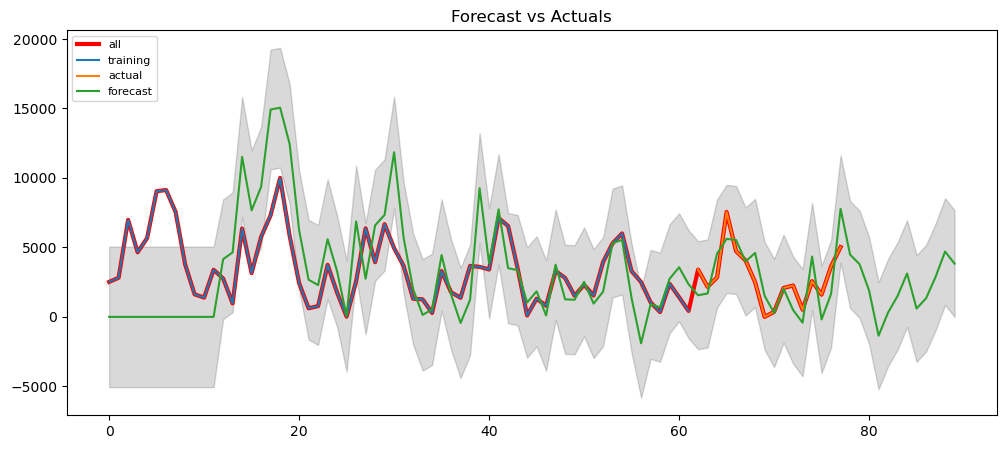

In [15]:
# p - trend autoregression order
# d - trend difference order
# q - trend moving average order

# SEASONAL ELEMENTS
# P - seasonal autoregression order, it says how many values of previous years are to be taken into account for autocorelation

# D - seasonal difference order, number of differencing to deseasonalize data; rarely more than 1

# Q - seasonal moving average order,how many residual values of the same season are to be taken from the previous years

# m - the number of time steps for a single seasonal period, in this case I noticed tere is a trend every 12 months or so
      # dat get a bit lowe then (see 12 months, 24 months, 36 months, 48 months, 60 months)
    
#Residual - is a difference (delta) between observed and predicted values of data.
            #They are a diagnostic measure used when assessing the quality of a model. 
            #They are also known as errors


val_prod_1_order = ans_df['pdq'].values[0]
print(val_prod_1_order)
val_prod_1_seasonal_order = ans_df['pdqs'].values[0]
print(val_prod_1_seasonal_order)

#define model
val_prod_1_sarimax_model = SARIMAX(val_prod_1, order=val_prod_1_order, seasonal_order=val_prod_1_seasonal_order )

#fit model
val_prod_1_train_model_fit = val_prod_1_sarimax_model.fit()


#Forecast
val_prod_1_train_model_fit_prediction = val_prod_1_train_model_fit.get_prediction(start=0,
                                                                           end = val_prod_1.index[-1] 
                                                                           + 12)

lower_series = val_prod_1_train_model_fit_prediction.conf_int()['lower y']
upper_series = val_prod_1_train_model_fit_prediction.conf_int()['upper y']


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(val_prod_1.index, val_prod_1, label='all', lw=3, color='r')
plt.plot(val_prod_1_train.index, val_prod_1_train, label='training')
plt.plot(val_prod_1_test.index, val_prod_1_test, label='actual')
plt.plot(val_prod_1_train_model_fit_prediction.predicted_mean, label='forecast')
plt.fill_between(lower_series.index, lower_series.values, upper_series.values, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

#Saving plot and showing it
plt.savefig(f'SARIMAX_{single_product_number}_{date.today()}.png', dpi=100, format='png')
plt.show()



# Fill in predictions in y_test_T2

In [16]:
#Overall prediction for all data train, text + 12 months of forecast
overall_prediction = val_prod_1_train_model_fit_prediction.predicted_mean

#choose the right place in y_test_T2 to add forecast
y_test_T2.loc[y_test_T2['key']==single_product_number,'y'] = overall_prediction[-12:].values

print(y_test_T2)

#saving data to the file
y_test_T2.to_csv('C:/Users/Ania/Desktop/Nestle Case/y_test_T2.csv',  sep=';', decimal=',')





     Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  \
0               0             0             0             0             0   
1               1             1             1             1             1   
2               2             2             2             2             2   
3               3             3             3             3             3   
4               4             4             4             4             4   
..            ...           ...           ...           ...           ...   
139           139           139           139           139           139   
140           140           140           140           140           140   
141           141           141           141           141           141   
142           142           142           142           142           142   
143           143           143           143           143           143   

     Unnamed: 0    key       date            y  
0             0  10873  01